## Business Understanding
A Real Estate firm is looking to enter the King County market, and would like a macro understanding of the value of different aspects of the market in order to make purchasing decisions. They would like to answer the following questions:

• What are the most important attributes in determining sales price?

• Do these attributes vary with different price points and locations?

• How much of sales price is explained with some combination of most important sales price and location?

## Data Understanding

The datasets used for analysis came from the King County Housing dataset (included in the data folder of this repository). The set comprises sales of  around 21,000 single-family homes between 2014-2015.


## Approach

After inspecting the data, we took several steps to clean the data and produce the set we will be using for this analysis, these are described in the "cleaning_script.py" file in the data folder.

Once the data was cleaned we took a look at the Pearson correlation coefficients for each variable in the set in order to determine possible predictors as well as detect possible multi-collinearity.

We then tried several regression models with different attributes on their own to find which explained the most variability in our response variable of price (we used a log_scaled version of price to more closely mimic a normal distribution).

Finally we settled on a vectorized approach to location, with sqft_living as our major predictor.

## Code

In [1]:
## Importing Libraries:
import pandas as pd
import numpy as np
import statsmodels as sm
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf
import math
import plotly.express as px

In [9]:
# Runs the cleaning_script on the raw dataset in the data folder, which creates a .pkl file
# in that folder which you can then import into this notebook for analysis.
# You only need to run this once, this is default commented out for this reason

%run ./data/cleaning_script.py

In [2]:
# Reading in the data:
df = pd.read_pickle('data/cleaned_df.pkl')

In [11]:
# Viewing the variables in the cleaned set:
df.columns

Index(['id', 'date', 'price', 'bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade',
       'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode',
       'lat', 'long', 'sqft_living15', 'sqft_lot15', 'yr_sold',
       'was_renovated', 'effective_age', 'log_price', 'space_needle_dist',
       'space_needle_bearing'],
      dtype='object')

In [12]:
# Brief High Level overview:
df.describe()

id         price      bedrooms     bathrooms   sqft_living  \
count  2.158700e+04  2.158700e+04  21587.000000  21587.000000  21587.000000   
mean   4.580283e+09  5.381927e+05      3.370547      2.113772   2076.789318   
std    2.876488e+09  3.522156e+05      0.901654      0.763319    902.747952   
min    1.000102e+06  7.800000e+04      1.000000      0.500000    370.000000   
25%    2.123049e+09  3.220000e+05      3.000000      1.750000   1428.500000   
50%    3.904930e+09  4.500000e+05      3.000000      2.250000   1910.000000   
75%    7.308900e+09  6.450000e+05      4.000000      2.500000   2550.000000   
max    9.900000e+09  5.300000e+06     10.000000      7.500000   7880.000000   

           sqft_lot        floors    waterfront          view     condition  \
count  2.158700e+04  21587.000000  19211.000000  21524.000000  21587.000000   
mean   1.507826e+04      1.493839      0.007444      0.232624      3.409969   
std    4.137164e+04      0.539580      0.085957      0.762946      0.650630   
min    5.200000e+02      1.000000      0.000000      0.000000      1.000000   
25%    5.040000e+03      1.000000      0.000000      0.000000      3.000000   
50%    7.616000e+03      1.500000      0.000000      0.000000      3.000000   
75%    1.066550e+04      2.000000      0.000000      0.000000      4.000000   
max    1.651359e+06      3.500000      1.000000      4.000000      5.000000   

       ...       zipcode           lat          long  sqft_living15  \
count  ...  21587.000000  21587.000000  21587.000000   21587.000000   
mean   ...  98077.964933     47.560058   -122.213980    1985.668180   
std    ...     53.510913      0.138570      0.140741     683.875927   
min    ...  98001.000000     47.155900   -122.519000     399.000000   
25%    ...  98033.000000     47.470950   -122.328000    1490.000000   
50%    ...  98065.000000     47.571800   -122.231000    1840.000000   
75%    ...  98118.000000     47.678000   -122.125000    2360.000000   
max    ...  98199.000000     47.777600   -121.315000    6210.000000   

          sqft_lot15       yr_sold  effective_age     log_price  \
count   21587.000000  21587.000000   21587.000000  21587.000000   
mean    12742.045815   2014.323065      41.390003     13.047134   
std     27239.770437      0.467658      28.950407      0.524228   
min       651.000000   2014.000000       0.000000     11.264464   
25%      5100.000000   2014.000000      16.000000     12.682307   
50%      7620.000000   2014.000000      37.000000     13.017003   
75%     10080.000000   2015.000000      61.000000     13.377006   
max    871200.000000   2015.000000     115.000000     15.483217   

       space_needle_dist  space_needle_bearing  
count       21587.000000          21587.000000  
mean           11.946260              1.737832  
std             7.043488              0.925863  
min             0.468652              0.001650  
25%             6.137758              0.978839  
50%            10.630657              1.821948  
75%            16.557606              2.490502  
max            48.600494              3.140774  

[8 rows x 25 columns]

## A Quick Look at Price

Price values are not perfectly log normally distributed, but as the histograms show, they do appear much more normal on a log scale, and so we've used log_price to capture the variability between more points in the dataset better in our models.

/Users/npardue/anaconda3/envs/maps/lib/python3.6/site-packages/ipykernel_launcher.py:9: UserWarning:

Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.



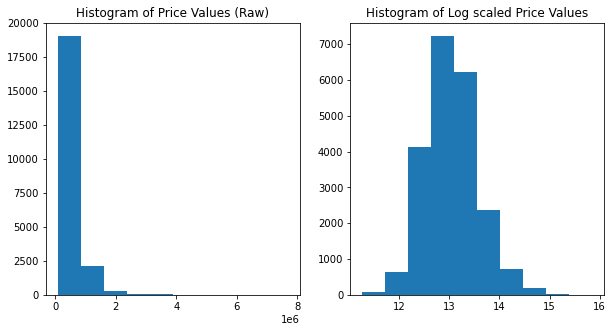

In [3]:
hist_fig = plt.figure(figsize=(10,5))
hist_ax_price = hist_fig.add_subplot(121)
hist_ax_log_price = hist_fig.add_subplot(122)
hist_ax_price.hist(df.price)
hist_ax_price.set_title('Histogram of Price Values (Raw)')
hist_ax_log_price.set_title('Histogram of Log scaled Price Values')
hist_ax_log_price
hist_ax_log_price.hist(df.log_price)
hist_fig.show()

## Correlation Values Between Variables

Big takeaways here are that sqft_living, and grade appear to correlate a fair amount with price/log_price. Interestingly Lat/Long do not appear to correlate significantly with our response variable, (more on this later), and there is predictable similarity between variables like sqft_living and sqft_living15(15 closest neighbors sqft), and sqft_above/sqft_basement.

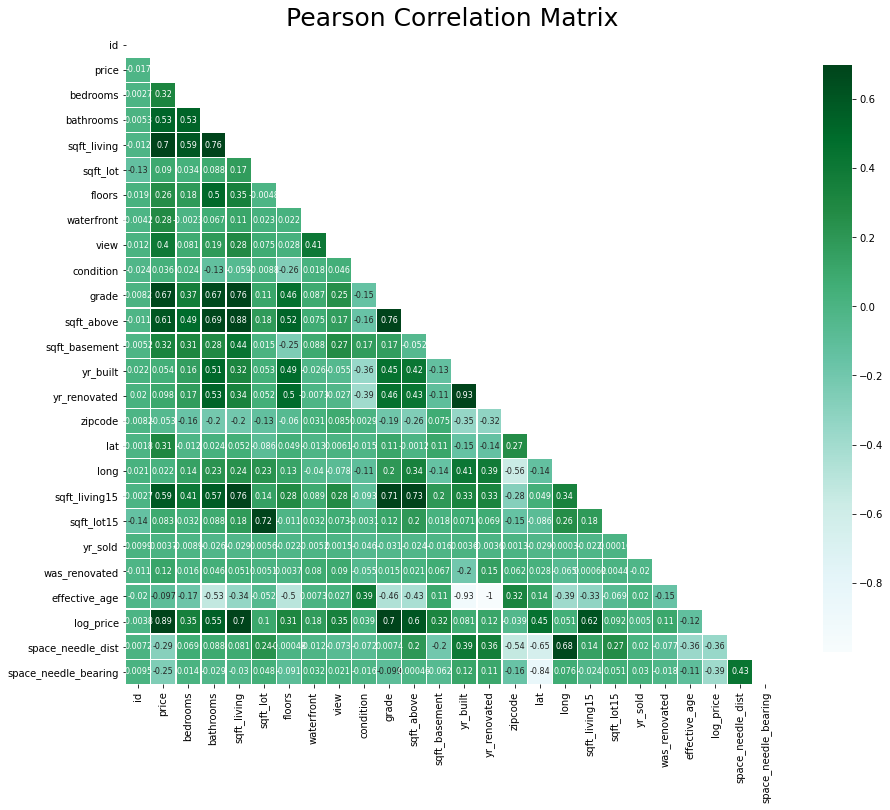

In [4]:
# No need to reinvent the wheel here, we really liked this visual for correlation among the
# numeric variables in the set. There are a lot of columns, but it was good to see both
# high and low correlation values to start.
# Code from: https://www.kaggle.com/burhanykiyakoglu/predicting-house-prices/notebook

features = list(df.columns)

mask = np.zeros_like(df[features].corr(), dtype=np.bool) 
mask[np.triu_indices_from(mask)] = True 

f, ax = plt.subplots(figsize=(16, 12))
plt.title('Pearson Correlation Matrix',fontsize=25)

sns.heatmap(df[features].corr(),linewidths=0.25,vmax=0.7,square=True,cmap="BuGn", #"BuGn_r" to reverse 
            linecolor='w',annot=True,annot_kws={"size":8},mask=mask,cbar_kws={"shrink": .9});


## Regression Models

Before modeling we used sklearn to split our data into train and test sets, then we started by trying a few of the more likely predictors based on the correlation matrix above. We tested sqft_living, and grade but given more time, we'd try all of them (and probably give backward elimination a shot as well).

In [5]:
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(df, test_size=0.2, random_state=16)

### Square Footage

For our first model, we tried a simple linear model with ordinary least squares method, and  square footage as our sole predictor. It was statistically significant as a coefficient, and described about half of the variability in both log_price and price. Predictably, the Kurtosis value for the price model was extremely large, representing the large outliers with this method.

In [16]:
formula = 'price ~ sqft_living '

model_price = smf.ols(formula=formula, data=train_set)
fitted_model_price = model_price.fit()

fitted_model_price.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.480
Model:                            OLS   Adj. R-squared:                  0.480
Method:                 Least Squares   F-statistic:                 1.596e+04
Date:                Fri, 10 Jul 2020   Prob (F-statistic):               0.00
Time:                        20:25:41   Log-Likelihood:            -2.3960e+05
No. Observations:               17269   AIC:                         4.792e+05
Df Residuals:                   17267   BIC:                         4.792e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept   -2.954e+04   4900.161     -6.027      0.000   -3.91e+04   -1.99e+04
sqft_living   273.5465      2.165    126.351      0.000     269.303     277.790
==============================================================================
Omnibus:                     9966.818   Durbin-Watson:                   1.982
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           175848.513
Skew:                           2.421   Prob(JB):                         0.00
Kurtosis:                      17.865   Cond. No.                     5.68e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.68e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [17]:
formula = 'log_price ~ sqft_living ' 

model_log_price = smf.ols(formula=formula, data=train_set)
fitted_model_log_price = model_log_price.fit()

fitted_model_log_price.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              log_price   R-squared:                       0.484
Model:                            OLS   Adj. R-squared:                  0.484
Method:                 Least Squares   F-statistic:                 1.618e+04
Date:                Fri, 10 Jul 2020   Prob (F-statistic):               0.00
Time:                        20:25:43   Log-Likelihood:                -7701.2
No. Observations:               17269   AIC:                         1.541e+04
Df Residuals:                   17267   BIC:                         1.542e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept      12.2043      0.007   1692.001      0.000      12.190      12.218
sqft_living     0.0004   3.19e-06    127.211      0.000       0.000       0.000
==============================================================================
Omnibus:                       38.221   Durbin-Watson:                   1.992
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               33.180
Skew:                           0.055   Prob(JB):                     6.24e-08
Kurtosis:                       2.816   Cond. No.                     5.68e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.68e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

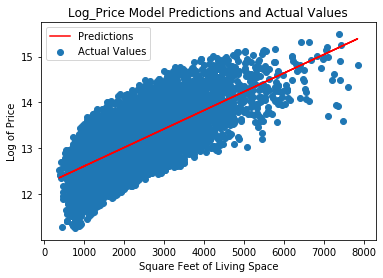

In [18]:
plt.plot(train_set.sqft_living, fitted_model_log_price.predict(train_set.sqft_living)\
         , color='red', label = 'Predictions')
plt.scatter(train_set.sqft_living, train_set.log_price, label='Actual Values')
plt.legend()
plt.xlabel('Square Feet of Living Space')
plt.ylabel('Log of Price')
plt.title('Log_Price Model Predictions and Actual Values');

Text(0.5, 1.0, 'Residual Plot Log Price by Square Footage Model')

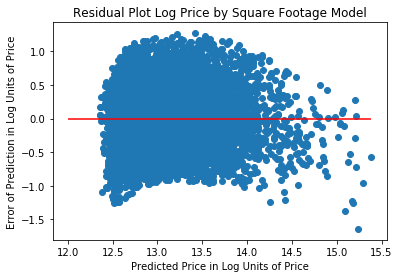

In [19]:
log_price_model_predictions =fitted_model_log_price.predict(train_set.sqft_living)
log_price_residuals = train_set.log_price - log_price_model_predictions
plt.scatter(log_price_model_predictions, log_price_residuals)
plt.hlines(y=0, xmin=12, xmax=log_price_model_predictions.max(), color='red')
#plt.xlim(0, 4000000)
plt.xlabel('Predicted Price in Log Units of Price')
plt.ylabel('Error of Prediction in Log Units of Price')
#plt.xticks(ticks=[0, 1000000, 2000000, 3000000, 4000000])
plt.title('Residual Plot Log Price by Square Footage Model')

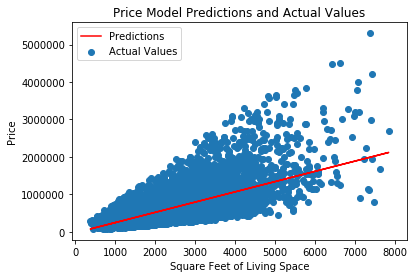

In [20]:
plt.plot(train_set.sqft_living, fitted_model_price.predict(train_set.sqft_living)\
         , color='red', label = 'Predictions')
plt.scatter(train_set.sqft_living, train_set.price, label='Actual Values')
plt.legend()
plt.xlabel('Square Feet of Living Space')
plt.ylabel('Price')
plt.title('Price Model Predictions and Actual Values');

Text(0.5, 1.0, 'Residual Plot Price by Square Footage Model')

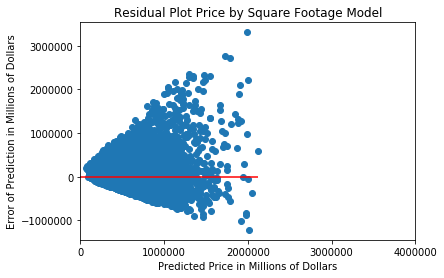

In [21]:

price_model_predictions =fitted_model_price.predict(train_set.sqft_living)
price_residuals = train_set.price - price_model_predictions
plt.scatter(price_model_predictions, price_residuals)
plt.hlines(y=0, xmin=0, xmax=price_model_predictions.max(), color='red')
plt.xlim(0, 4000000)
plt.xlabel('Predicted Price in Millions of Dollars')
plt.ylabel('Error of Prediction in Millions of Dollars')
plt.xticks(ticks=[0, 1000000, 2000000, 3000000, 4000000])
plt.title('Residual Plot Price by Square Footage Model')

### Square footage observations:
The errors here in both models were substantially bigger above 8000 square feet of living space. So much so in fact, that after determining we were only looking at removing about 8-9 values from our training set of almost 18,000 observations, we decided to remove the observations with square feet above 8000 and rebuild the test_train splits. (We actually did this later, but it's best visualized here, so we included these initial plots before doing this in our technical notebook).

Additionally, the log_price model is far more homoscedastic, so we'll be using this as our response moving forward. Last, there is some room certainly for polynomial regression here. Our project took us in a different direction, but it's worth looking at in future.

Below is a quick look at the log_price by square footage after filtering the dataset. There is still some room for removing outliers, but we did want to remove too many observations to fit the model. The slight curvature of residuals that still remains indicates there is likely a slightly better fit with polynomial model.

In [6]:
## Filtering the data and rebuilding test/train splits:
df = df[df.sqft_living < 8000]

train_set, test_set = train_test_split(df, test_size=0.2, random_state=16)

In [23]:
formula = 'log_price ~ sqft_living ' 

model_log_price = smf.ols(formula=formula, data=train_set)
fitted_model_log_price = model_log_price.fit()

fitted_model_log_price.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              log_price   R-squared:                       0.484
Model:                            OLS   Adj. R-squared:                  0.484
Method:                 Least Squares   F-statistic:                 1.618e+04
Date:                Fri, 10 Jul 2020   Prob (F-statistic):               0.00
Time:                        20:25:56   Log-Likelihood:                -7701.2
No. Observations:               17269   AIC:                         1.541e+04
Df Residuals:                   17267   BIC:                         1.542e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept      12.2043      0.007   1692.001      0.000      12.190      12.218
sqft_living     0.0004   3.19e-06    127.211      0.000       0.000       0.000
==============================================================================
Omnibus:                       38.221   Durbin-Watson:                   1.992
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               33.180
Skew:                           0.055   Prob(JB):                     6.24e-08
Kurtosis:                       2.816   Cond. No.                     5.68e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.68e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

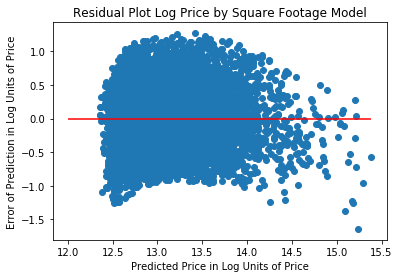

In [24]:
log_price_model_predictions =fitted_model_log_price.predict(train_set.sqft_living)
log_price_residuals = train_set.log_price - log_price_model_predictions
plt.scatter(log_price_model_predictions, log_price_residuals)
plt.hlines(y=0, xmin=12, xmax=log_price_model_predictions.max(), color='red')
#plt.xlim(0, 4000000)
plt.xlabel('Predicted Price in Log Units of Price')
plt.ylabel('Error of Prediction in Log Units of Price')
#plt.xticks(ticks=[0, 1000000, 2000000, 3000000, 4000000])
plt.title('Residual Plot Log Price by Square Footage Model');

### Grade

The next predictor we looked at was grade. Grade was a building grade given by the county based off of building quality, condition, age, etc. Interestingly, grade describes about the same amount of variance in the response variable, as sqft_living (both as a continuous predictor and a categorical). Grade is an ordinal categorical, but we wanted to see how much the model would pick up as a pure category. Interestingly it did about as well, although the std. errors of the coefficients of each category and intercept were a bit larger than the continuous model.

In [25]:
formula = 'log_price ~ grade ' 

model_log_price_grade = smf.ols(formula=formula, data=train_set)
fitted_model_log_price_grade = model_log_price_grade.fit()

fitted_model_log_price_grade.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              log_price   R-squared:                       0.494
Model:                            OLS   Adj. R-squared:                  0.494
Method:                 Least Squares   F-statistic:                 1.687e+04
Date:                Fri, 10 Jul 2020   Prob (F-statistic):               0.00
Time:                        20:26:09   Log-Likelihood:                -7524.7
No. Observations:               17269   AIC:                         1.505e+04
Df Residuals:                   17267   BIC:                         1.507e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     10.6311      0.019    565.328      0.000      10.594      10.668
grade          0.3155      0.002    129.897      0.000       0.311       0.320
==============================================================================
Omnibus:                       89.609   Durbin-Watson:                   1.997
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               91.055
Skew:                           0.173   Prob(JB):                     1.69e-20
Kurtosis:                       3.084   Cond. No.                         52.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [26]:
formula = 'log_price ~ C(grade) ' 

model_log_price_grade_categorical = smf.ols(formula=formula, data=train_set)
fitted_model_log_price_grade_categorical = model_log_price_grade_categorical.fit()

fitted_model_log_price_grade_categorical.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              log_price   R-squared:                       0.496
Model:                            OLS   Adj. R-squared:                  0.496
Method:                 Least Squares   F-statistic:                     1888.
Date:                Fri, 10 Jul 2020   Prob (F-statistic):               0.00
Time:                        20:26:13   Log-Likelihood:                -7492.4
No. Observations:               17269   AIC:                         1.500e+04
Df Residuals:                   17259   BIC:                         1.508e+04
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept         12.1497      0.076    159.351      0.000      12.000      12.299
C(grade)[T.5]      0.1670      0.081      2.066      0.039       0.009       0.325
C(grade)[T.6]      0.3906      0.077      5.087      0.000       0.240       0.541
C(grade)[T.7]      0.6876      0.076      9.003      0.000       0.538       0.837
C(grade)[T.8]      0.9820      0.076     12.848      0.000       0.832       1.132
C(grade)[T.9]      1.3406      0.077     17.482      0.000       1.190       1.491
C(grade)[T.10]     1.6538      0.077     21.411      0.000       1.502       1.805
C(grade)[T.11]     1.9741      0.079     24.988      0.000       1.819       2.129
C(grade)[T.12]     2.3713      0.089     26.580      0.000       2.196       2.546
C(grade)[T.13]     2.6977      0.160     16.813      0.000       2.383       3.012
==============================================================================
Omnibus:                       79.967   Durbin-Watson:                   1.998
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               81.104
Skew:                           0.163   Prob(JB):                     2.45e-18
Kurtosis:                       3.078   Cond. No.                         99.1
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

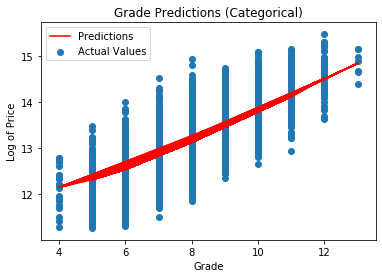

In [27]:
price_model_predictions_cat = fitted_model_log_price_grade_categorical.predict(train_set.grade)
price_residuals_cat = train_set.log_price - price_model_predictions_cat

plt.plot(train_set.grade, price_model_predictions_cat\
         , color='red', label = 'Predictions')
plt.scatter(train_set.grade, train_set.log_price, label='Actual Values')
plt.legend()
plt.xlabel('Grade')
plt.ylabel('Log of Price')
plt.title('Grade Predictions (Categorical)');

Text(0.5, 1.0, 'Residual Plot Price by Grade (Categorical) Model')

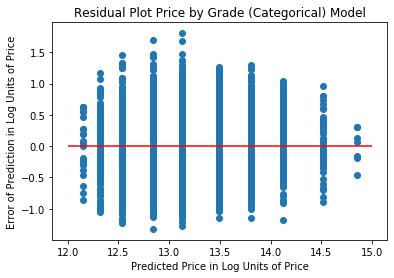

In [28]:

plt.scatter(price_model_predictions_cat, price_residuals_cat)
plt.hlines(y=0, xmin=12, xmax=15, color='red')
#plt.xlim(0, 4000000)
plt.xlabel('Predicted Price in Log Units of Price')
plt.ylabel('Error of Prediction in Log Units of Price')
#plt.xticks(ticks=[0, 1000000, 2000000, 3000000, 4000000])
plt.title('Residual Plot Price by Grade (Categorical) Model')

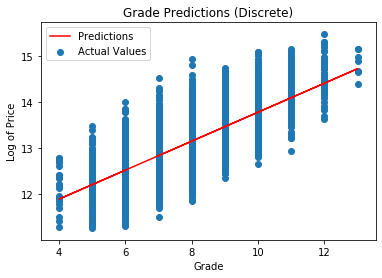

In [29]:
price_model_predictions_grade = fitted_model_log_price_grade.predict(train_set.grade)
price_residuals_grade = train_set.log_price - price_model_predictions_grade

plt.plot(train_set.grade, price_model_predictions_grade\
         , color='red', label = 'Predictions')
plt.scatter(train_set.grade, train_set.log_price, label='Actual Values')
plt.legend()
plt.xlabel('Grade')
plt.ylabel('Log of Price')
plt.title('Grade Predictions (Discrete)');

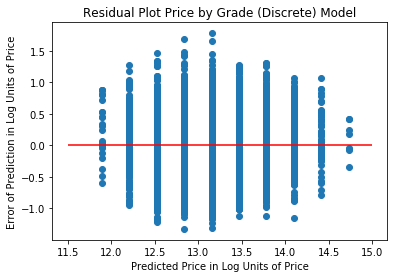

In [30]:
plt.scatter(price_model_predictions_grade, price_residuals_grade)
plt.hlines(y=0, xmin=11.5, xmax=15, color='red')
#plt.xlim(0, 4000000)
plt.xlabel('Predicted Price in Log Units of Price')
plt.ylabel('Error of Prediction in Log Units of Price')
#plt.xticks(ticks=[0, 1000000, 2000000, 3000000, 4000000])
plt.title('Residual Plot Price by Grade (Discrete) Model');

### Observations: Grade

Grade is really an ordinal categorical variable, and we can get the same model accuracy out of square feet with less clutter than the categorical version of grade (which is anyway failing to account for its ordinality). We decided that since our client really was interested in one feature by location, square footage was going to be a better implementation in this use case.

## Location Variables

Next, our client was very interested in the impact of location, and wanted to see how the old real estate adage "Location, Location, Location" played out in King County.

We first tested latitude and longitude, and then tried representing location as a vector measuring distance and bearing from a single location (we chose the space needle as it roughly approximates Seattle's downtown business district). Ultimately this led us to our final approach of using several vectors to relate each point to multiple locations on the map, loosely weighted by density with a kmeans clustering algorithm to find our centers to measure from.

In [31]:
formula = 'log_price ~ long ' 

model_log_price_long = smf.ols(formula=formula, data=train_set)
fitted_model_log_price_long = model_log_price_long.fit()

fitted_model_log_price_long.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              log_price   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                  0.002
Method:                 Least Squares   F-statistic:                     41.38
Date:                Fri, 10 Jul 2020   Prob (F-statistic):           1.29e-10
Time:                        20:26:27   Log-Likelihood:                -13390.
No. Observations:               17269   AIC:                         2.678e+04
Df Residuals:                   17267   BIC:                         2.680e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     35.3368      3.465     10.198      0.000      28.545      42.129
long           0.1824      0.028      6.433      0.000       0.127       0.238
==============================================================================
Omnibus:                      631.565   Durbin-Watson:                   1.996
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              777.445
Skew:                           0.421   Prob(JB):                    1.51e-169
Kurtosis:                       3.611   Cond. No.                     1.06e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.06e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

## WOW!

This performed so badly that we did not even plot the residuals, etc. Latitude maybe?

In [32]:
formula = 'log_price ~ lat ' 

model_log_price_lat = smf.ols(formula=formula, data=train_set)
fitted_model_log_price_lat = model_log_price_lat.fit()

fitted_model_log_price_lat.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              log_price   R-squared:                       0.201
Model:                            OLS   Adj. R-squared:                  0.201
Method:                 Least Squares   F-statistic:                     4352.
Date:                Fri, 10 Jul 2020   Prob (F-statistic):               0.00
Time:                        20:26:30   Log-Likelihood:                -11470.
No. Observations:               17269   AIC:                         2.294e+04
Df Residuals:                   17267   BIC:                         2.296e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -67.7523      1.225    -55.320      0.000     -70.153     -65.352
lat            1.6988      0.026     65.973      0.000       1.648       1.749
==============================================================================
Omnibus:                     1258.299   Durbin-Watson:                   2.002
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1942.491
Skew:                           0.584   Prob(JB):                         0.00
Kurtosis:                       4.155   Cond. No.                     1.63e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.63e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

## Latitude: Better, but Not Great
Last try, lat/long pairs? We factored in interaction of these two as well for this one. It did not perform much better than the latitude model as you can see below.

In [33]:
formula = 'log_price ~ lat*long ' 

model_log_price_latlong = smf.ols(formula=formula, data=train_set)
fitted_model_log_price_latlong = model_log_price_latlong.fit()

fitted_model_log_price_latlong.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              log_price   R-squared:                       0.215
Model:                            OLS   Adj. R-squared:                  0.214
Method:                 Least Squares   F-statistic:                     1573.
Date:                Fri, 10 Jul 2020   Prob (F-statistic):               0.00
Time:                        20:26:37   Log-Likelihood:                -11325.
No. Observations:               17269   AIC:                         2.266e+04
Df Residuals:                   17265   BIC:                         2.269e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   4019.5020   1124.089      3.576      0.000    1816.173    6222.831
lat          -83.1589     23.638     -3.518      0.000    -129.492     -36.826
long          33.4683      9.198      3.639      0.000      15.439      51.497
lat:long      -0.6949      0.193     -3.592      0.000      -1.074      -0.316
==============================================================================
Omnibus:                     1402.165   Durbin-Watson:                   2.000
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2290.886
Skew:                           0.615   Prob(JB):                         0.00
Kurtosis:                       4.293   Cond. No.                     1.84e+09
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.84e+09. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

## Relation to a Single Anchor Point

What's going on here? We thought about what the problem was in our location approach, and realized that the spherical space described by longitude and latitude might not be best suited for identifying differences in location at the county level. Instead, we decided to represent location as the bearing and distance components of a vector between each observation and a common (local) point. We started with the Space Needle (specific function for calculating distance and bearing appear in the cleaning script, but the generalized versions also appear below in the section following this one. In order to capture the full scope of the vector in the model, we decided two represent the two components and their interaction as well.

In [34]:
formula = 'log_price ~ space_needle_dist*space_needle_bearing' 

model_log_price_space_needle = smf.ols(formula=formula, data=train_set)
fitted_model_log_price_space_needle = model_log_price_space_needle.fit()

fitted_model_log_price_space_needle.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              log_price   R-squared:                       0.218
Model:                            OLS   Adj. R-squared:                  0.218
Method:                 Least Squares   F-statistic:                     1606.
Date:                Fri, 10 Jul 2020   Prob (F-statistic):               0.00
Time:                        20:26:41   Log-Likelihood:                -11285.
No. Observations:               17269   AIC:                         2.258e+04
Df Residuals:                   17265   BIC:                         2.261e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==========================================================================================================
                                             coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------
Intercept                                 13.2734      0.015    905.658      0.000      13.245      13.302
space_needle_dist                          0.0144      0.002      9.124      0.000       0.011       0.017
space_needle_bearing                      -0.0196      0.008     -2.532      0.011      -0.035      -0.004
space_needle_dist:space_needle_bearing    -0.0155      0.001    -21.861      0.000      -0.017      -0.014
==============================================================================
Omnibus:                     1120.262   Durbin-Watson:                   2.003
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1684.458
Skew:                           0.544   Prob(JB):                         0.00
Kurtosis:                       4.076   Cond. No.                         156.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Relation to Multiple Points

As can be seen from the above results, our first try was not much different than the results of latitude and longitude. This was a bit disappointing as it is more difficult to explain the coefficients in a model with additional points, but we were of course interested in whether or not the approach would be more succesful with more reference points.

You can generally understand our approach as follows. For each mile away from each point in our model, (points being the center of a circle with distance being effectively the radius), there would be some small correlation with house price. Likewise with a given house's bearing in radians relative to each point, and then last with the interaction between distance and bearing.  This would in theory allow us to effectively flatten the curvature of the space on which our regression function was operating to conform to the natural shape of the relative location of houses to each other within the geographic space, and to the space itself.


We briefly considered representing bearing in a more carefully chosen range emphasizing the negative direction of 270 degrees vs. 90 degrees as -pi/2 and pi/2 (you could also choose for example some offset or scaled version of -pi and 0 radians for 180 and 0 depending on the direction you were trying to represent). This approach turned out to be too technically challenging for the time we had to implement it, but for those interested, we have included an outline of the basic idea below:

1) Once you have obtained your anchor points, determine the bearing range in which most of the data lie for each point (two diametrically opposed i.e. directly opposite points on the unit circle, such as 90/270, 0/180, etc. would require at most an offset but in theory no scaling, so this is desirable, but you could choose a smaller range if the data warranted it)

2) Recalculate bearing to represent these endpoints as opposites. You could use some version of the following function adapted to the range of your endpoints:

```python
def get_bearing(lat1,lon1,lat2,lon2):
    """Return the bearing in radians between -pi and pi of vector extending from 
    (lat1,lon1) to (lat2, lon2) where lat/lon pairs are latitude and longitude in
    radians"""
    # first calculate bearing on a -pi to zero type range:
    difference_lon = (lon2 - lon1)
    y = np.sin(difference_lon) * np.cos(lat2)
    x = np.cos(lat1)*np.sin(lat2) - np.sin(lat1)*np.cos(lat2)*np.cos(dLon)
    brng = np.arctan2(y, x)
    # then add pi/2 to make range from -pi/2 to pi/2
    brng += (np.pi)/2
    return brng
```


### Mapping Our Intuition: Location Matters when it Comes to Price
First, to explain why we felt strongly that location ought to be a reasonable predictor of price, we set aside our train_test splits, and made a map representing price with color for the whole dataset across King County. Note, in order to represent information interactively, we used plotly for this visualization. You will need to run in jupyter notebooks vs. jupyter lab, or have the proper extensions for plotly installed to run in lab. 

In [7]:
## Helper functions

def find_map_center(df, lat, long):
    """A function for finding the center of a list of given coordinates. Returns a dictionary
    -------------------------------------------------------------------
    df: a pandas dataframe
    lat: string. the dataframe column that contains the latitude values
    long: string. the dataframe column that contains the longitude values"""
    
    mid_lat = (df[lat].sort_values().iloc[0] + df[lat].sort_values().iloc[-1]) / 2
    mid_long = (df[long].sort_values().iloc[0] + df[long].sort_values().iloc[-1]) / 2
    
    return {"lat": mid_lat, "lon": mid_long}

def generate_5_ticks(dataframe, column):
    """A function specifically built for this project's map, generates the ticks needed for the scatterplot
    ------------------------------------------------------------------------
    dataframe: a pandas dataframe
    column: a column within the dataframe that you would like to sort. Must be a number (float, int, etc)"""
    
    logged = np.log(dataframe[column]).sort_values()
    list_of_logs = []
    
    l1, l5 = logged.iloc[0], logged.iloc[-1]
    l3 = np.mean([l1, l5])
    
    l2, l4 = np.mean([l1, l3]), np.mean([l3, l5])
    
    return [l1, l2, l3, l4, l5]

In [9]:
# Creating string columns for neatly organized hover data
df["coordinates"] = [(abs(df.lat.loc[i]).astype(str) + "° N, " + abs(df.long.loc[i]).astype(str) + "° W") for i in df.index]
df["sale_price"] = df.price.apply(lambda x: "$" + str(x/1000) + "K")

# Setting the values for the scatterplot colorscale.
# Ticktext was manually obtained but you can verify by using np.exp(tickvalues)
tickvalues, ticktext = generate_5_ticks(df, "price")\
                        , ["$78K", "$245K", "$775K", "$2.4M" , "$7.7M"]

# finding the centerpoint of the map
coordinates = find_map_center(df, "lat", "long")

# Public read-only mapbox token
mapbox_token = "pk.eyJ1Ijoicm5odyIsImEiOiJja2NkZWwyMzYwZHZyMnptbGVycTRyeXR0In0.DJD_rTPSqw_4Qaj8LxM8gg"
px.set_mapbox_access_token(mapbox_token)

#Creating the initial map
fig = px.scatter_mapbox(df, lat="lat", lon="long", color=np.log(df.price),
                        center = coordinates,
                        zoom=8.4, width = 800, height = 600)

#Adding hover data
fig.update_traces(
    customdata = np.stack((df.sale_price, df.coordinates), axis = -1),
    hovertemplate="<b>%{customdata[0]}</b><br>"+
                  "%{customdata[1]}"
)

#Updating the color scale to reflect acutal prices instead of log prices
fig.update_coloraxes(colorbar = {"title": None, "tickvals" : tickvalues, "ticktext": ticktext})

#Adding and positioning map title
fig.update_layout(
    title = {
        "text" : "House sales in King County during May 2014 - May 2015",
        'x':0.5, 'y' : .95,
        "xanchor" : 'center', "yanchor" : "top"}) 

fig.show()

### Defining Geographic Location Points to Measure From

As you can see, there are some clear price patterns in the set, but they do not follow a continuous distribution across all locations. One way to capture this information is through zipcode, but there are several limitations to this approach. First, one-hot encoding 70 zipcodes is by no means impossible to implement, but the model would then be understood in a binary sense by each zipcode's coefficient, which is a lot to ask of a human. Next, to the extent that location *within* each zipcode has a predictive effect on price, the model would not capture this information as each point within a category would be assigned the same weight.

Instead, we ran a quick K-means clustering with lat and long as classifiers to find how many points might reasonably represent the location density in the set, and where to put each center to measure from. Note that we did *not* use the cluster information directly in our model as a categorical, and that all anchor points were determined exclusively from the training set in order to ensure no data leakage from the test data.

In [10]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
# define scaler
scaler = StandardScaler()

# select latitude and longitude cols FROM THE TRAIN SET ONLY
train_lat_long = train_set[['lat', 'long']]

# scale columns
train_scaled = scaler.fit_transform(train_lat_long)
pd.DataFrame(train_scaled).describe()

0             1
count  1.726900e+04  1.726900e+04
mean   2.989595e-14  5.517209e-15
std    1.000029e+00  1.000029e+00
min   -2.912024e+00 -2.166252e+00
25%   -6.526990e-01 -8.118653e-01
50%    8.865324e-02 -1.169447e-01
75%    8.501588e-01  6.347042e-01
max    1.562721e+00  6.371345e+00

/Users/npardue/anaconda3/envs/maps/lib/python3.6/site-packages/sklearn/cluster/_kmeans.py:974: FutureWarning:

'n_jobs' was deprecated in version 0.23 and will be removed in 0.25.

/Users/npardue/anaconda3/envs/maps/lib/python3.6/site-packages/sklearn/cluster/_kmeans.py:974: FutureWarning:

'n_jobs' was deprecated in version 0.23 and will be removed in 0.25.

/Users/npardue/anaconda3/envs/maps/lib/python3.6/site-packages/sklearn/cluster/_kmeans.py:974: FutureWarning:

'n_jobs' was deprecated in version 0.23 and will be removed in 0.25.

/Users/npardue/anaconda3/envs/maps/lib/python3.6/site-packages/sklearn/cluster/_kmeans.py:974: FutureWarning:

'n_jobs' was deprecated in version 0.23 and will be removed in 0.25.

/Users/npardue/anaconda3/envs/maps/lib/python3.6/site-packages/sklearn/cluster/_kmeans.py:974: FutureWarning:

'n_jobs' was deprecated in version 0.23 and will be removed in 0.25.

/Users/npardue/anaconda3/envs/maps/lib/python3.6/site-packages/sklearn/cluster/_kmeans.py:974: 

Text(0, 0.5, 'Inertia')

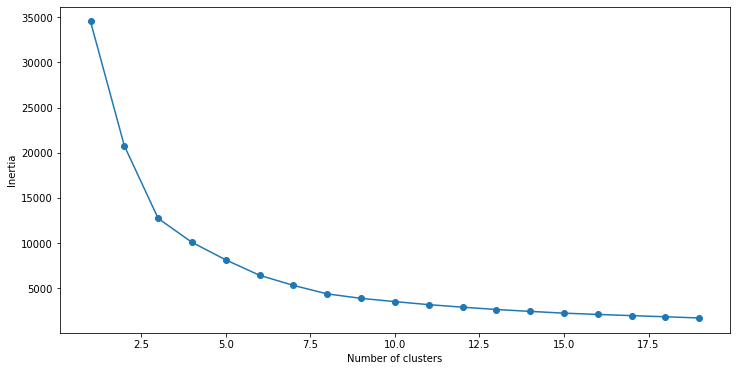

In [11]:
# Simple plot to visually estimate a good number of points to use for these data
SSE = []
for cluster in range(1,20):
    kmeans = KMeans(n_jobs = -1, n_clusters = cluster, init='k-means++')
    kmeans.fit(train_scaled)
    SSE.append(kmeans.inertia_)

# converting the results into a dataframe and plotting them
frame = pd.DataFrame({'Cluster':range(1,20), 'SSE':SSE})
plt.figure(figsize=(12,6))
plt.plot(frame['Cluster'], frame['SSE'], marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')

In [12]:
# Definite "elbow" at around 3, but 6 or 7 points appear to capture about as much
# will be captured by using additional points and performed a little better in the modeling

# Find our six points, setting random_state for reproducibility
kmeans = KMeans(n_jobs = -1, n_clusters = 6, init='k-means++', random_state=16)
kmeans.fit(train_scaled)
train_pred = kmeans.predict(train_scaled)


train_frame = pd.DataFrame(train_scaled)
train_frame['cluster'] = train_pred
train_frame['cluster'].value_counts()

# Sorting the points again for reproducibility and to aid visuals
train_centers = kmeans.cluster_centers_
train_centers_frame = pd.DataFrame(scaler.inverse_transform(train_centers), columns=['klat', 'klong'])
train_centers_frame.sort_values(by='klat', inplace=True)
train_centers_frame.reset_index(drop=True, inplace=True)
train_centers_frame['size'] = 0.5
train_centers_frame['cluster'] = train_centers_frame.index
train_centers_frame

/Users/npardue/anaconda3/envs/maps/lib/python3.6/site-packages/sklearn/cluster/_kmeans.py:974: FutureWarning:

'n_jobs' was deprecated in version 0.23 and will be removed in 0.25.



klat       klong  size  cluster
0  47.331219 -122.302298   0.5        0
1  47.392456 -122.116310   0.5        1
2  47.534714 -122.314791   0.5        2
3  47.557735 -121.924715   0.5        3
4  47.653663 -122.122049   0.5        4
5  47.695238 -122.325940   0.5        5

In [41]:
# Denser regions have more points in them, visualized below
train_frame['cluster'].value_counts()

2    4402
0    3637
1    3457
4    2801
3    1618
5    1354
Name: cluster, dtype: int64

In [13]:
# The clusters
train_set['cluster'] = train_frame['cluster']
mapbox_token = 'pk.eyJ1IjoibnBhcmR1ZSIsImEiOiJja2NkdmszamkwMGpoMndwNjZvcTB3OWF2In0.oab4wnhdjwGV7tghW4nVPQ' 
px.set_mapbox_access_token(mapbox_token)
fig = px.scatter_mapbox(train_centers_frame, lat="klat", lon="klong", size='size',
                        title='Geographic Points of Interest',
                        hover_data = [train_centers_frame.klat, train_centers_frame.klong],
                        center = coordinates,
                        zoom=8.4, width = 900, height = 650)
fig.show() 

/Users/npardue/anaconda3/envs/maps/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [14]:
mapbox_token = 'pk.eyJ1IjoibnBhcmR1ZSIsImEiOiJja2NkdmszamkwMGpoMndwNjZvcTB3OWF2In0.oab4wnhdjwGV7tghW4nVPQ' 
px.set_mapbox_access_token(mapbox_token)
train_set['cluster'] = train_pred
fig = px.scatter_mapbox(train_set, lat="lat", lon="long",
                        title='Geographic Clusters by Lat & Long',
                        hover_data = [train_set.lat, train_set.long],
                        center = coordinates,
                        color='cluster',
                        color_discrete_sequence=px.colors.qualitative.G10,
                        zoom=8.4, width = 900, height = 650)

fig.show() 

/Users/npardue/anaconda3/envs/maps/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [15]:
# Create a Function for computing the distance relative from anchor point
# of a given lat/long point
def distance_from(flat, flong, lat, long):
    """return 'as the crow flies' distance in miles from the 
    space needle, given latitude and longitude coordinates of a location"""
    # Convert lat/longitudes to radians
    def to_radians(latlong):
        return latlong / 57.29577951
    # lat/long of input
    loc_lat = to_radians(lat)
    loc_long = to_radians(long)
    c_lat = to_radians(flat)
    c_long = to_radians(flong)
    # distance in miles
    d = 3963.0 * np.arccos((np.sin(c_lat) * np.sin(loc_lat))\
                           + np.cos(c_lat) * np.cos(loc_lat)\
                           * np.cos(loc_long - c_long))
    return d

# Add lat/long in radians columns for anchor points and train_set
train_centers_frame['lat_rad'] = train_centers_frame.klat.map(math.radians)
train_centers_frame['long_rad'] = train_centers_frame.klong.map(math.radians)

train_set['lat_rad'] = train_set.lat.map(math.radians)
train_set['long_rad'] = train_set.long.map(math.radians)
    
# Create a Function for computing the bearing relative from anchor point
# of a given lat/long point
def bearing_from(flat, flong, lat, long):
    """return bearing theta in radians for given location's
    bearing relative to the anchor point. Takes latitude and longitude
    of the location as lat, long, anchor point as flat, flong."""
    delta_fi = np.log(np.tan(flat / 2 + np.pi/4) / np.tan(lat / 2 + np.pi/4))
    delta_lon = abs(flong - long)
    bearing = np.arctan2(delta_lon, delta_fi)
    return bearing

/Users/npardue/anaconda3/envs/maps/lib/python3.6/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/Users/npardue/anaconda3/envs/maps/lib/python3.6/site-packages/ipykernel_launcher.py:25: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [16]:
# Adding our feature vectors for each anchor point to each observation in the set
for i in train_centers_frame.index:
    dist_col_name = f'dist_c{i}'
    bear_col_name = f'bear_c{i}'
    train_set[dist_col_name] = distance_from(train_centers_frame.loc[i, 'klat'], train_centers_frame.loc[i, 'klong'], train_set.lat, train_set.long)
    train_set[bear_col_name] = bearing_from(train_centers_frame.loc[i, 'lat_rad'], train_centers_frame.loc[i, 'long_rad'], train_set.lat_rad, train_set.long_rad)


/Users/npardue/anaconda3/envs/maps/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/Users/npardue/anaconda3/envs/maps/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [46]:
train_set.head()

id       date     price  bedrooms  bathrooms  sqft_living  \
12702  5014000085 2014-06-23  425000.0         2        1.0          880   
10450  6056100295 2014-05-30  330000.0         2        2.5         1240   
10209  8947250060 2015-03-26  292500.0         4        2.5         1610   
7095   9297300480 2014-12-12  765000.0         4        3.5         2760   
19486  8151600900 2014-11-12  445000.0         5        3.0         2420   

       sqft_lot  floors  waterfront  view  ...    dist_c1   bear_c1  \
12702      6413     1.0         0.0   0.0  ...  18.044456  2.335117   
10450      1546     2.0         0.0   0.0  ...  14.557210  2.518737   
10209      4568     2.0         NaN   0.0  ...   9.009377  1.114804   
7095       4000     2.0         0.0   2.0  ...  17.136687  2.362214   
19486     11250     2.0         0.0   0.0  ...  14.003878  2.179333   

         dist_c2   bear_c2    dist_c3   bear_c3    dist_c4   bear_c4  \
12702   4.585313  2.187132  21.934190  1.617268  13.878366  1.155954   
10450   2.136555  2.764615  17.388716  1.591210  10.298298  0.917715   
10209  13.857255  0.087378  22.963753  0.833636  23.379654  0.339068   
7095    3.628044  2.276528  20.943728  1.605254  13.119502  1.105118   
19486   2.864527  0.877109  20.675087  1.402502  15.042417  0.836835   

         dist_c5   bear_c5  
12702   9.041648  0.363008  
10450   9.210171  0.142789  
10209  24.967637  0.069503  
7095    9.030014  0.249750  
19486  13.042291  0.128668  

[5 rows x 42 columns]

In [47]:
# Modeling our new features, first build formula:
col_combos = [f'+ dist_c{i}*bear_c{i} ' if i != 0 else f' dist_c{i}*bear_c{i} ' for i in train_centers_frame.index]
formula = 'log_price ~' + ''.join(col_combos)
formula

'log_price ~ dist_c0*bear_c0 + dist_c1*bear_c1 + dist_c2*bear_c2 + dist_c3*bear_c3 + dist_c4*bear_c4 + dist_c5*bear_c5 '

In [48]:
# Fitting our model and generating summary stats
model_anchors = smf.ols(formula=formula, data=train_set)
fitted_model_anchors = model_anchors.fit()

fitted_model_anchors.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              log_price   R-squared:                       0.453
Model:                            OLS   Adj. R-squared:                  0.452
Method:                 Least Squares   F-statistic:                     792.2
Date:                Fri, 10 Jul 2020   Prob (F-statistic):               0.00
Time:                        20:27:36   Log-Likelihood:                -8208.5
No. Observations:               17269   AIC:                         1.646e+04
Df Residuals:                   17250   BIC:                         1.660e+04
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept          16.2983      0.138    117.806      0.000      16.027      16.569
dist_c0            -0.1290      0.010    -12.401      0.000      -0.149      -0.109
bear_c0            -0.0708      0.017     -4.224      0.000      -0.104      -0.038
dist_c0:bear_c0     0.0287      0.005      5.484      0.000       0.018       0.039
dist_c1             0.0650      0.008      8.056      0.000       0.049       0.081
bear_c1             0.0455      0.015      3.072      0.002       0.016       0.075
dist_c1:bear_c1    -0.0194      0.005     -4.081      0.000      -0.029      -0.010
dist_c2             0.2266      0.012     19.620      0.000       0.204       0.249
bear_c2             0.1364      0.015      9.189      0.000       0.107       0.165
dist_c2:bear_c2    -0.1184      0.007    -16.513      0.000      -0.132      -0.104
dist_c3             0.0995      0.008     12.487      0.000       0.084       0.115
bear_c3            -0.0811      0.025     -3.249      0.001      -0.130      -0.032
dist_c3:bear_c3    -0.0572      0.005    -11.544      0.000      -0.067      -0.047
dist_c4            -0.0621      0.010     -6.178      0.000      -0.082      -0.042
bear_c4            -0.0150      0.013     -1.134      0.257      -0.041       0.011
dist_c4:bear_c4     0.0154      0.005      3.065      0.002       0.006       0.025
dist_c5            -0.2773      0.009    -30.284      0.000      -0.295      -0.259
bear_c5            -0.2331      0.012    -18.728      0.000      -0.257      -0.209
dist_c5:bear_c5     0.1811      0.006     28.023      0.000       0.168       0.194
==============================================================================
Omnibus:                     1784.942   Durbin-Watson:                   1.984
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             3573.500
Skew:                           0.673   Prob(JB):                         0.00
Kurtosis:                       4.776   Cond. No.                     4.24e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.24e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [49]:
# We just made the predictors for this model, so they are the last 12 in the set
columns = train_set.columns[-12:]

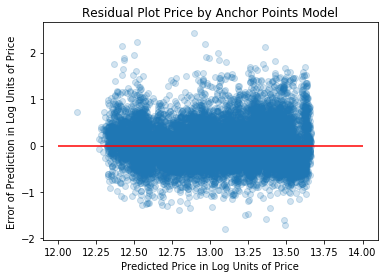

In [50]:
model_predictions_anchors = fitted_model_anchors.predict(train_set[columns])
residuals_anchors = train_set.log_price - model_predictions_anchors
plt.scatter(model_predictions_anchors, residuals_anchors, alpha=0.2)
plt.hlines(y=0, xmin=12, xmax=14, color='red')
#plt.xlim(0, 4000000)
plt.xlabel('Predicted Price in Log Units of Price')
plt.ylabel('Error of Prediction in Log Units of Price')
#plt.xticks(ticks=[0, 1000000, 2000000, 3000000, 4000000])
plt.title('Residual Plot Price by Anchor Points Model');

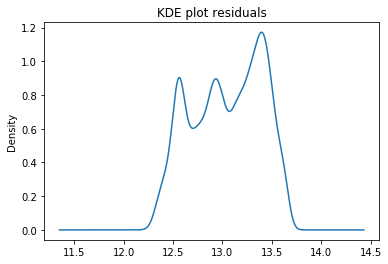

In [51]:
model_predictions_anchors.plot(kind='kde', title='KDE plot residuals')

### Anchor Points Method - Conclusions

This model did a lot better than both just latitude and longitude, and the single anchor point method, describing almost twice as much of the variation in the data. There is some skew, residuals are not completely normally distributed, and we'd definitely like the accuracy to be better. Biggest issue is there is of course clear multicollinearity introduced by using location vectors but we're getting there!

Polynomial regression would likely be worth a shot here, time constraints did not permit us to pursue this approach.

Last, let's take a look at predicting with location and square footage.

In [52]:
col_combos = [f'+ dist_c{i}*bear_c{i} ' for i in train_centers_frame.index]
formula = 'log_price ~ sqft_living ' + ''.join(col_combos)
formula

'log_price ~ sqft_living + dist_c0*bear_c0 + dist_c1*bear_c1 + dist_c2*bear_c2 + dist_c3*bear_c3 + dist_c4*bear_c4 + dist_c5*bear_c5 '

In [53]:
# Initial fit:

model = smf.ols(formula=formula, data=train_set)
fitted_model = model.fit()

fitted_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              log_price   R-squared:                       0.805
Model:                            OLS   Adj. R-squared:                  0.804
Method:                 Least Squares   F-statistic:                     3740.
Date:                Fri, 10 Jul 2020   Prob (F-statistic):               0.00
Time:                        20:27:51   Log-Likelihood:                 689.28
No. Observations:               17269   AIC:                            -1339.
Df Residuals:                   17249   BIC:                            -1183.
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept          14.8508      0.083    178.815      0.000      14.688      15.014
sqft_living         0.0004   2.11e-06    176.325      0.000       0.000       0.000
dist_c0            -0.0309      0.006     -4.961      0.000      -0.043      -0.019
bear_c0            -0.0123      0.010     -1.228      0.219      -0.032       0.007
dist_c0:bear_c0    -0.0050      0.003     -1.582      0.114      -0.011       0.001
dist_c1             0.0704      0.005     14.620      0.000       0.061       0.080
bear_c1            -0.0112      0.009     -1.269      0.204      -0.029       0.006
dist_c1:bear_c1    -0.0306      0.003    -10.796      0.000      -0.036      -0.025
dist_c2             0.1236      0.007     17.845      0.000       0.110       0.137
bear_c2             0.1347      0.009     15.196      0.000       0.117       0.152
dist_c2:bear_c2    -0.0570      0.004    -13.257      0.000      -0.065      -0.049
dist_c3             0.0649      0.005     13.628      0.000       0.056       0.074
bear_c3            -0.0988      0.015     -6.623      0.000      -0.128      -0.070
dist_c3:bear_c3    -0.0257      0.003     -8.669      0.000      -0.032      -0.020
dist_c4            -0.0800      0.006    -13.318      0.000      -0.092      -0.068
bear_c4            -0.0280      0.008     -3.535      0.000      -0.043      -0.012
dist_c4:bear_c4     0.0227      0.003      7.567      0.000       0.017       0.029
dist_c5            -0.1701      0.006    -30.912      0.000      -0.181      -0.159
bear_c5            -0.1872      0.007    -25.159      0.000      -0.202      -0.173
dist_c5:bear_c5     0.1015      0.004     26.117      0.000       0.094       0.109
==============================================================================
Omnibus:                     1082.249   Durbin-Watson:                   2.015
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             4142.911
Skew:                           0.208   Prob(JB):                         0.00
Kurtosis:                       5.363   Cond. No.                     1.07e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.07e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [54]:
# Tuning a bit to filter out variables that are not statistically significant: 

formula = 'log_price ~ '
# Excludes the Intercept coefficient
formula_join = ' + '.join(list(fitted_model.pvalues[fitted_model.pvalues < .05].index[1:]))
formula += formula_join
formula

'log_price ~ sqft_living + dist_c0 + dist_c1 + dist_c1:bear_c1 + dist_c2 + bear_c2 + dist_c2:bear_c2 + dist_c3 + bear_c3 + dist_c3:bear_c3 + dist_c4 + bear_c4 + dist_c4:bear_c4 + dist_c5 + bear_c5 + dist_c5:bear_c5'

In [55]:
# Second Fit:

model = smf.ols(formula=formula, data=train_set)
fitted_model = model.fit()

fitted_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              log_price   R-squared:                       0.805
Model:                            OLS   Adj. R-squared:                  0.804
Method:                 Least Squares   F-statistic:                     4439.
Date:                Fri, 10 Jul 2020   Prob (F-statistic):               0.00
Time:                        20:27:57   Log-Likelihood:                 685.92
No. Observations:               17269   AIC:                            -1338.
Df Residuals:                   17252   BIC:                            -1206.
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept          14.7422      0.066    222.966      0.000      14.613      14.872
sqft_living         0.0004   2.11e-06    176.593      0.000       0.000       0.000
dist_c0            -0.0394      0.003    -14.146      0.000      -0.045      -0.034
dist_c1             0.0711      0.005     14.951      0.000       0.062       0.080
dist_c1:bear_c1    -0.0314      0.003    -11.997      0.000      -0.037      -0.026
dist_c2             0.1350      0.004     31.079      0.000       0.127       0.144
bear_c2             0.1326      0.007     18.130      0.000       0.118       0.147
dist_c2:bear_c2    -0.0638      0.003    -23.684      0.000      -0.069      -0.059
dist_c3             0.0652      0.004     15.051      0.000       0.057       0.074
bear_c3            -0.0955      0.015     -6.558      0.000      -0.124      -0.067
dist_c3:bear_c3    -0.0260      0.003     -9.405      0.000      -0.031      -0.021
dist_c4            -0.0764      0.006    -13.417      0.000      -0.088      -0.065
bear_c4            -0.0245      0.008     -3.217      0.001      -0.039      -0.010
dist_c4:bear_c4     0.0214      0.003      7.467      0.000       0.016       0.027
dist_c5            -0.1762      0.004    -41.162      0.000      -0.185      -0.168
bear_c5            -0.1874      0.007    -26.369      0.000      -0.201      -0.173
dist_c5:bear_c5     0.1058      0.003     36.830      0.000       0.100       0.111
==============================================================================
Omnibus:                     1082.410   Durbin-Watson:                   2.015
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             4154.989
Skew:                           0.207   Prob(JB):                         0.00
Kurtosis:                       5.367   Cond. No.                     8.50e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 8.5e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

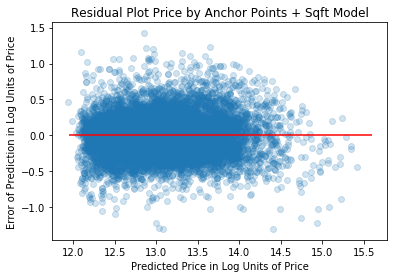

In [56]:
# Add sqft_living to columns:
columns = list(columns)
columns.append('sqft_living')
model_predictions = fitted_model.predict(train_set[columns])
residuals = train_set.log_price - model_predictions
plt.scatter(model_predictions, residuals, alpha=0.2)
plt.hlines(y=0, xmin=11.95, xmax=15.6, color='red')
#plt.xlim(0, 4000000)
plt.xlabel('Predicted Price in Log Units of Price')
plt.ylabel('Error of Prediction in Log Units of Price')
#plt.xticks(ticks=[0, 1000000, 2000000, 3000000, 4000000])
plt.title('Residual Plot Price by Anchor Points + Sqft Model');

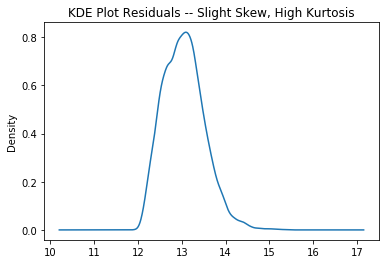

In [57]:
model_predictions.plot(kind='kde', title='KDE Plot Residuals -- Slight Skew, High Kurtosis')

## Analysis and Testing on our Test Set

Long story short, we like our R^2, but there are definitely some issues indicated by the residuals. In particular, our model does not perform as well on the larger sales prices, and we'd like it to be a bit more accurate overall. That said, let's see how it performs on the test set:

In [58]:
# Adding the necessary columns to model on:

test_set['lat_rad'] = test_set.lat.map(math.radians)
test_set['long_rad'] = test_set.long.map(math.radians)

# Adding our feature vectors for each anchor point to each observation in the set
# note we are still using the centers determined from the training data
for i in train_centers_frame.index:
    dist_col_name = f'dist_c{i}'
    bear_col_name = f'bear_c{i}'
    test_set[dist_col_name] = distance_from(train_centers_frame.loc[i, 'klat'], train_centers_frame.loc[i, 'klong'], test_set.lat, test_set.long)
    test_set[bear_col_name] = bearing_from(train_centers_frame.loc[i, 'lat_rad'], train_centers_frame.loc[i, 'long_rad'], test_set.lat_rad, test_set.long_rad)
test_set.head()

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/p

id       date      price  bedrooms  bathrooms  sqft_living  \
6899   1137800460 2014-12-09   465000.0         3       2.50         2870   
4359   2770605550 2015-03-10  1140000.0         4       3.25         2960   
12762  7812800155 2015-03-18   170000.0         3       1.00          790   
17616  7010700210 2014-06-05   605004.0         4       2.00         1370   
6316   5112800233 2014-09-09   289000.0         3       1.50         1970   

       sqft_lot  floors  waterfront  view  ...    dist_c1   bear_c1  \
6899      25663     2.0         0.0   0.0  ...  12.923874  0.904019   
4359       4296     2.0         0.0   0.0  ...  21.595217  2.555682   
12762      6750     1.0         NaN   0.0  ...   9.335561  2.473373   
17616      4000     2.0         0.0   0.0  ...  22.557058  2.529113   
6316      22486     1.0         0.0   0.0  ...   4.253200  2.835969   

         dist_c2   bear_c2    dist_c3   bear_c3    dist_c4   bear_c4  \
6899   17.850171  0.047625  27.247691  0.775253  27.868315  0.360793   
4359    8.580897  2.825681  21.819619  1.874470  11.620249  1.563233   
12762   4.303678  0.948292  15.259665  1.295986  12.068313  0.471137   
17616   9.377048  2.736922  22.936280  1.880393  12.649709  1.600488   
6316   12.034411  1.069720  10.643740  0.800395  14.112578  0.111387   

         dist_c5   bear_c5  
6899   28.934687  0.011119  
4359    3.639996  0.627435  
12762  14.192579  0.286937  
17616   4.020059  0.904952  
6316   20.186514  0.580121  

[5 rows x 41 columns]

In [59]:
# Same predictor columns
test_x_preds = test_set[columns]

# Same fitted model on the test data
test_preds = fitted_model.predict(test_x_preds)

# Calculating R_sq
log_price_mean = test_set.log_price.mean()
TSS = ((test_set.log_price - (log_price_mean))**2).sum()
RSS = ((test_set.log_price - test_preds)**2).sum()

R_sq = 1 - (RSS / TSS)

R_sq

0.8000139971660403

In [60]:
# Calculating RMSE
RMSE = np.sqrt(np.mean((test_set.log_price - test_preds)**2))

RMSE

0.23110477566396592

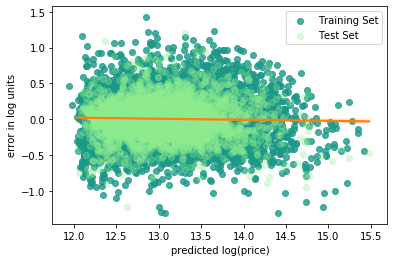

In [61]:
# Residual plot for both Test and Train sets

# Calculating Residuals
test_residuals = test_set.log_price - test_preds

sns.regplot(model_predictions, residuals, fit_reg=False,
            scatter_kws={"color":"#1a9988"},
            label='Training Set')

sns.regplot(test_preds, test_residuals, fit_reg=True,
            scatter_kws={"color":"lightgreen", 'alpha':0.3},
            label='Test Set')

plt.legend()
plt.ylabel('error in log units')
plt.xlabel('predicted log(price)')
plt.show()

# Conclusion:

For a first attempt, our model worked reasonably well, and explains about 80% of the variation in sales price with an average RMSE on the test data of about .231 log units, with a combination of location and square footage. Our model does not do as well at either extreme of the data set, this is likely do to a number of factors, but we'd like to highlight two elements as areas for further research. First, a more complex polynomial regression model would likely do better a capturing some of this variation than our linear model. Next, in completing this project we encountered strong possibilities for further research in the area of geostatistics. A large part of the issue with the model is that it does not do a great job of capturing cycles and discontinuities in the location-sq_ft-price space. These are clearly visible in for example the gaps along the water, or the clustering of density with lower square footage exacerbated by this breakoff imposed by the waterline in what is effectively the city center. This results in assigning too much weight to lower square footage values in the urban areas, which is only partially offset by our vectorized location method.

The strong collinearity introduced by the vectors also is an area for improvement. In particular we'd like to further explore methods that directly account for and even utilize autocorrelation of neighboring points, such as variograms and kriging. This is a technical way of saying that the most predictive features in the dataset clearly do vary quite a bit with location, and this is difficult to capture in a linear model. Last, there is presumably a moderate to strong spatiotemporal effect, likely present even over the course of the year's worth of data we looked at, but our model effectively assumes static effect. A longer time series would allow the model to account for cyclical and longer term trends that behave differently on different regions within the space.